In [1]:
! pip install btester requests tqdm yfinance QuantStats

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
import pandas as pd
import requests

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [3]:
from btester import Strategy

def UpBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).max().diff() > 0).values

def DownBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).min().diff() < 0).values

class BreakoutStrategy(Strategy):
    buy_at_once_size = .01 # 1%

    def init(self, buy_period: int, sell_period: int):
        self.buy_signal = {}
        self.sell_signal = {}

        for symbol in self.symbols:
            self.buy_signal[symbol] = UpBreakout(self.data[(symbol,'Close')], buy_period)
            self.sell_signal[symbol] = DownBreakout(self.data[(symbol,'Close')], sell_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.buy_signal[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self.positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.sell_signal[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def positionSize(self, price: float):
        return round((self.cash + self.assets_value) / price * self.buy_at_once_size) if price > 0 else 0

In [4]:
from btester import Backtest
backtest = Backtest(BreakoutStrategy, data, commission=.001, cash=1e6)

In [5]:
import pandas as pd
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Buy period','Sell period']
values = [[5, 10, 20, 50, 75, 100, 150, 200], [5, 10, 20, 50, 75, 100, 150, 200]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


In [6]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Buy period Sell period                                                         
20         100             1.000044e+06       3.938022e+07        -35.745374   
5          75              1.000350e+06       5.296988e+07        -50.495765   
20         75              1.000044e+06       3.587932e+07        -40.117509   
5          100             1.000350e+06       4.180663e+07        -53.376220   
           50              1.000350e+06       3.523947e+07        -50.331383   
...                                 ...                ...               ...   
75         5               1.000000e+06       1.183799e+06        -29.146472   
50         5               1.000000e+06       1.190721e+06        -33.105845   
200        5               1.000000e+06       1.082152e+06        -30.317287   
100        5               1.000000e+06       1.051097e+06        -32.133251   
150        5               1.000000e+06       1.023543e+06        -32.506856   

                         CAGR (%)  Sharpe Ratio  
Buy period Sell period                           
20         100          22.641932      1.107580  
5          75           24.676764      1.095960  
20         75           22.009124      1.064722  
5          100          23.047966      1.059899  
           50           21.885127      1.056548  
...                           ...           ...  
75         5             0.941931      0.147313  
50         5             0.974637      0.147180  
200        5             0.439650      0.094677  
100        5             0.277285      0.075813  
150        5             0.129382      0.057626  

[64 rows x 5 columns]

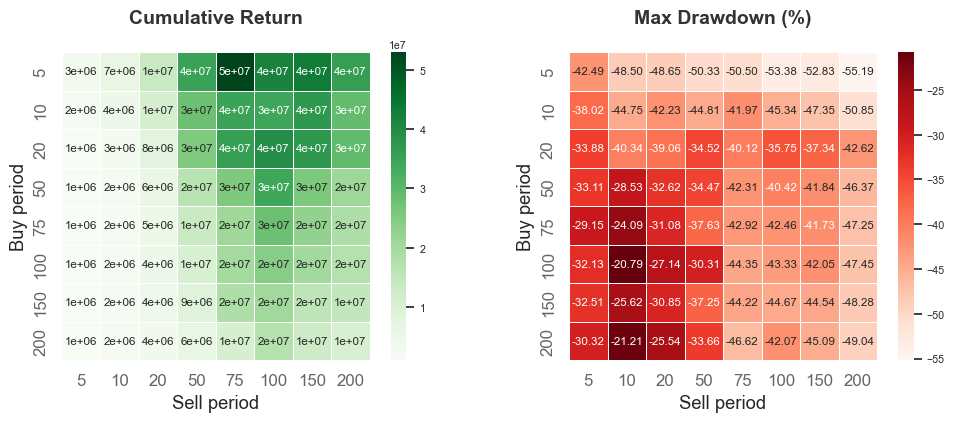

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [8]:
best_params = optimization_results_sorted.index[0]
best_params

(20, 100)

In [9]:
result = backtest.run(*best_params)

In [10]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   3,837.85%   905.52%
CAGR﹪              22.64%      13.68%

Sharpe              1.11        0.69
Prob. Sharpe Ratio  100.0%      99.82%
Sortino             1.59        0.97
Sortino/√2          1.12        0.69
Omega               1.21        1.21

Max Drawdown        -35.75%     -53.85%
Longest DD Days     759         1161

Gain/Pain Ratio     0.21        0.14
Gain/Pain (1M)      1.49        0.83

Payoff Ratio        0.93        0.87
Profit Factor       1.21        1.14
Common Sense Ratio  1.16        1.04
CPC Index           0.63        0.55
Tail Ratio          0.96        0.92
Outlier Win Ratio   3.81        3.87
Outlier Loss Ratio  3.91        3.78

MTD                 6.49%       6.49%
3M                  11.51%      1

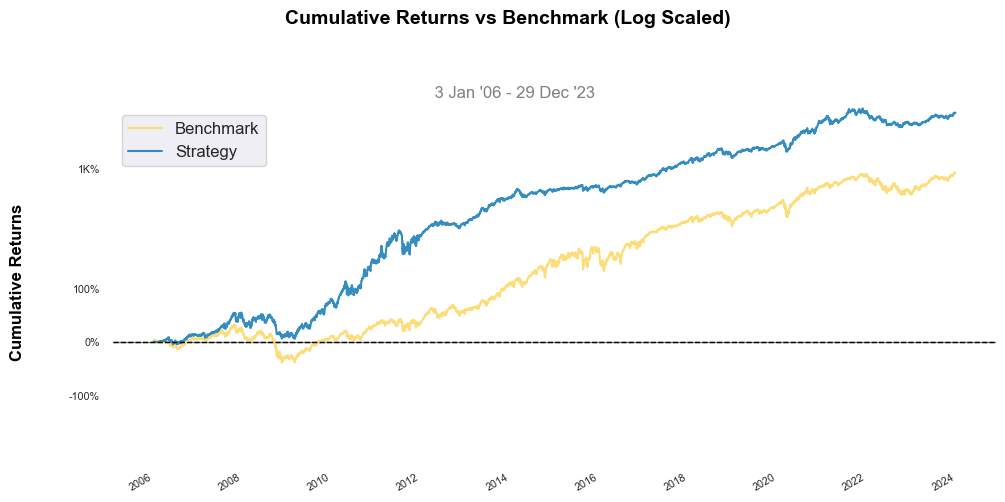

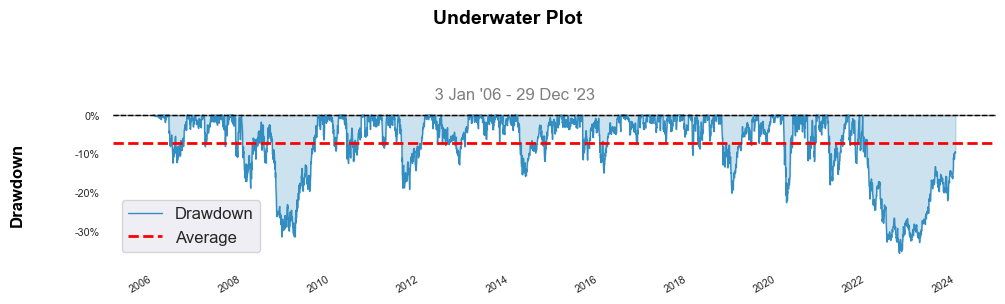

In [11]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [14]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,AZN,2006-03-23,2007-05-04,25.575001,26.715000,398,453.719757,4.457475,20.811420,1.000433e+06
1,AZN,2006-03-27,2007-05-04,25.745001,26.715000,396,384.119728,3.767719,20.774160,1.000796e+06
2,MAR,2006-01-03,2007-05-10,31.285149,41.576805,320,3293.330078,32.896300,23.315825,1.004066e+06
3,MAR,2006-02-16,2007-05-10,32.277958,41.576805,311,2891.941479,28.808660,22.968831,1.006935e+06
4,MAR,2006-03-22,2007-05-10,32.184734,41.576805,315,2958.502293,29.181756,23.234885,1.009871e+06
...,...,...,...,...,...,...,...,...,...,...
1631,TSLA,2023-06-01,2023-10-27,202.589996,210.600006,1673,13400.746338,3.953803,691.266874,2.871942e+07
1632,AAPL,2023-06-29,2023-10-27,189.080002,166.910004,1890,-41901.296539,-11.725195,672.821110,2.867685e+07
1633,CMCSA,2023-08-11,2023-10-27,45.680000,38.000000,7796,-59873.282379,-16.812610,652.369282,2.861632e+07
1634,CSCO,2023-08-18,2023-11-17,54.630001,48.049999,6405,-42144.911728,-12.044667,657.665402,2.857352e+07


In [13]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,VRTX,2021-12-02,2023-12-29,201.820007,406.890015,2026,415471.834839,101.610346,824359.169678
1,VRTX,2022-01-31,2023-12-29,240.869995,406.890015,1444,239732.908203,68.925156,587549.181152
2,VRTX,2022-02-01,2023-12-29,242.389999,406.890015,1477,242966.522537,67.865843,600976.551636
3,VRTX,2022-02-02,2023-12-29,243.580002,406.890015,1472,240392.338867,67.045739,598942.101562
4,VRTX,2022-02-03,2023-12-29,250.160004,406.890015,1443,226161.405853,62.651906,587142.291138
...,...,...,...,...,...,...,...,...,...
80,MSFT,2023-11-03,2023-12-29,349.630005,376.040009,1013,26753.333710,7.553701,380928.528656
81,AMZN,2023-11-03,2023-12-29,138.990005,151.940002,2547,32983.642227,9.317215,386991.186218
82,PEP,2023-11-03,2023-12-29,168.679993,169.839996,2099,2434.847687,0.687695,356494.152313
83,AVGO,2023-11-20,2023-12-29,973.000000,1116.250000,379,54291.750000,14.722508,423058.750000
